# Testing Oh 2004 soil model Jacobian and coupling

This notebook aims to test Oh's 2004 soil model derivatives and its coupling into a standard WCM. The function below calculates the Oh model and its Jacobian. Simple tests with finite difference approximations.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
%matplotlib inline

Text(0.5, 0, '$\\frac{\\partial \\sigma_{VH}}{\\partial ks}$')

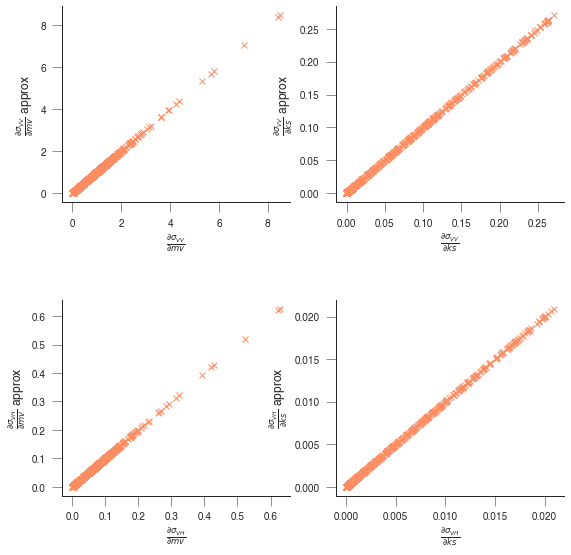

In [54]:
def oh2004(mv, ks, theta):
    """Oh 2004 soil model as a function of volumetric soil moisture,
    rms height and angle of incidence. 
    Parameters
    ----------
    mv : float, ndarray
        volumetric soil moisture m3/m3
    ks : float
        product of wavenumber and rms height
        be aware that both need to have the same units
    theta : float, ndarray
        incidence angle [rad]
    
    Returns
    -------
    Backscatter (linear units) in HH, VV and HV polarisations,
    Jacobian (d_dmv, d_dks), although I left out HH for the time
    being. It's quite easy to calculate

    """
    p1 = (2.*theta/np.pi)**(0.35*mv**(-0.65))
    p2 = np.exp(-0.4*ks**1.4)
    p = 1 - p1*p2
    #p = 1 - (2.*theta/np.pi)**(0.35*mv**(-0.65)) * np.exp(-0.4 * ks**1.4)
    dp_dmv = 0.2275*p1*np.log(2.*theta/np.pi)*p2/(mv**1.65)
    dp_dks = 0.56*p1*np.exp(-0.4*ks**1.4)*ks**0.4
    q0 = 0.095 * (0.13 + np.sin(1.5*theta))**1.4
    q = q0 * (1-np.exp(-1.3 * ks**0.9))
    dq_dmv = 0.
    dq_dks = q0 * (-1.17*np.exp(-1.3*ks**0.9)/ks**0.1)
    a = 0.11 * mv**0.7 * np.cos(theta)**2.2
    da_dmv = 0.7*0.11*np.cos(theta)**2.2/mv**0.3
    da_dks = 0.
    b = 1 - np.exp(-0.32 * ks**1.8)
    db_mv = 0.
    db_mks = 0.576*np.exp(-0.32 * ks**1.8)*(ks**0.8)
    
    hv = a*b
    dhv_dmv = da_dmv*b
    dhv_dks = db_mks*a
    vv = a*b/q
    dvv_dmv = (da_dmv*b*q)/(q*q)
    dvv_dks = (db_mks*a*q + dq_dks*a*b)/(q*q)
    hh = hv/q*p
    
    return [[hh, None],  [vv, np.array([dvv_dmv, dvv_dks])], 
            [hv, np.array([dhv_dmv, dhv_dks])]]

oh2004_vv = lambda x:oh2004(x[0], x[1],np.deg2rad(30))[1][0]
oh2004_dvv = lambda x:oh2004(x[0], x[1],np.deg2rad(30))[1][1]

oh2004_vh = lambda x:oh2004(x[0], x[1],np.deg2rad(30))[2][0]
oh2004_dvh = lambda x:oh2004(x[0], x[1],np.deg2rad(30))[2][1]


# this next is quite a bit of lame, spaghetti-grade code
# 

n_test = 1000
test_x = np.random.rand(n_test,2)*np.array([0.5, 10])

exact_mv_vv = []
exact_ks_vv = []
approx_mv_vv = []
approx_ks_vv = []

exact_mv_vh = []
exact_ks_vh = []
approx_mv_vh = []
approx_ks_vh = []

for i in range(n_test):
    a, b = oh2004_dvv((test_x[i, 0], test_x[i, 1]))
    exact_mv_vv.append(a)
    exact_ks_vv.append(b)
    a, b = oh2004_dvh((test_x[i, 0], test_x[i, 1]))
    exact_mv_vh.append(a)
    exact_ks_vh.append(b)
    a, b  = scipy.optimize.approx_fprime(
        np.array([test_x[i, 0], test_x[i, 1]]), oh2004_vv, 1e-5)
    approx_mv_vv.append(a)
    approx_ks_vv.append(b)
    a, b  = scipy.optimize.approx_fprime(
        np.array([test_x[i, 0], test_x[i, 1]]), oh2004_vh, 1e-5)
    approx_mv_vh.append(a)
    approx_ks_vh.append(b)

fig, axs = plt.subplots(nrows=2, ncols=2, squeeze=True,
                       figsize=(9,9))
axs = axs.flatten()
axs[0].plot(exact_mv_vv, approx_mv_vv, 'x')
axs[1].plot(exact_ks_vv, approx_ks_vv, 'x')
axs[2].plot(exact_mv_vh, approx_mv_vh, 'x')
axs[3].plot(exact_ks_vh, approx_ks_vh, 'x')
axs[0].set_ylabel(r"$\frac{\partial \sigma_{VV}}{\partial mv}$ approx")
axs[1].set_ylabel(r"$\frac{\partial \sigma_{VV}}{\partial ks}$ approx")
axs[2].set_ylabel(r"$\frac{\partial \sigma_{VH}}{\partial mv}$ approx")
axs[3].set_ylabel(r"$\frac{\partial \sigma_{VH}}{\partial ks}$ approx")

axs[0].set_xlabel(r"$\frac{\partial \sigma_{VV}}{\partial mv}$")
axs[1].set_xlabel(r"$\frac{\partial \sigma_{VV}}{\partial ks}$")
axs[2].set_xlabel(r"$\frac{\partial \sigma_{VH}}{\partial mv}$")
axs[3].set_xlabel(r"$\frac{\partial \sigma_{VH}}{\partial ks}$")

The above plots suggest that the derivatives of the Oh model are accurate. We can easily couple the model to the WCM as

$$
\sigma_{pq}^{0} = A_{pq}\cdot V_{1}\left[1 - \exp\left(-\frac{-2B_{pq}\cdot V_{2}}{\cos\theta}\right)\right] + \exp\left(-\frac{-2B_{pq}\cdot V_{2}}{\cos\theta}\right)\cdot\sigma_{soil,pq}.
$$

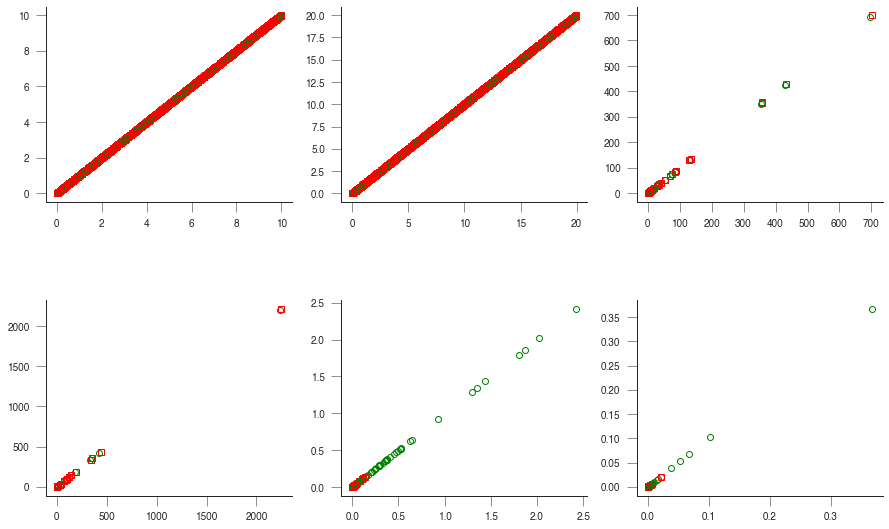

In [60]:
def wcm(A, V1, B, V2, mv, ks, theta=23, pol="VV"):
    """WCM model with Oh2004 model. The main
    assumption here is that we only consider first
    order effects. The vegetation backscatter contribution
    is given by `A*V1`, which is often related to scatterer
    (e.g. leaves, stems, ...) properties. The attenuation
    due to the canopy is controlled by `B*V2`, which is
    often related to canopy moisture content (this is polarisation
    and frequency dependent). The soil backscatter is modelled as
    using an Oh2004 model.
    """
    mu = np.cos(np.deg2rad(theta))
    tau = np.exp(-2*B*V2/mu)
    veg = A*V1*(1-tau)
    isel = ["HH", "VV", "HV"].index(pol.upper())
    (sigma_soil, (dsoil_dmv, dsoil_dks)) = oh2004(
                            mv, ks, np.deg2rad(theta))[isel]
    soil = tau*sigma_soil
    
    der_dA = V1 - V1*tau
    der_dV1 = A - A*tau
    der_dB = (-2 * V2 / mu) * tau * (-A * V1 + sigma_soil)
    der_dV2 = (-2 * B / mu) * tau * (-A * V1 + sigma_soil)
    der_dmv = tau*dsoil_dmv
    der_dks = tau*dsoil_dks
    
    return veg + soil, np.array([der_dA, der_dB, 
                                 der_dmv, der_dks, der_dV1, der_dV2])





wcm_vv = lambda x:wcm(x[0], x[1], x[2], x[3], x[4], x[5], pol="VV")[0]
wcm_vh = lambda x:wcm(x[0], x[1], x[2], x[3], x[4], x[5], pol="HV")[0]

wcm_dvv = lambda x:(wcm(x[0], x[1], x[2], x[3], x[4], x[5], pol="VV")[1][np.array([0,4,1,5,2,3])])
wcm_dvh = lambda x:(wcm(x[0], x[1], x[2], x[3], x[4], x[5], pol="HV")[1][np.array([0,4,1,5,2,3])])

n_test = 1000
test_x = np.random.rand(n_test,6)*np.array([20,10,20, 10, 0.5, 10])


fig, axs = plt.subplots(nrows=2, ncols=3, squeeze=True,figsize=(15,9))
axs = axs.flatten()
for i in range(n_test):    
    d_vv_approx = scipy.optimize.approx_fprime(test_x[i], wcm_vv, 1e-3)
    d_vv = wcm_dvv(test_x[i])
    [axs[j].plot(d_vv[j], d_vv_approx[j], 'go', mfc="none") for j in range(6)]
    d_vh_approx = scipy.optimize.approx_fprime(test_x[i], wcm_vh, 1e-3)
    d_vh = wcm_dvh(test_x[i])
    [axs[j].plot(d_vh[j], d_vh_approx[j], 'rs', mfc="none") for j in range(6)]


It would appear that this Jacobian is also nailed...

In [83]:
def cost_obs(x, svh, svv, theta, unc=0.5):
    """Cost function. Order of parameters is
    A_vv, B_vv, A_vh, B_vh, ks,
    vsm_0, ..., vsm_N,
    LAI_0, ..., LAI_N
    
    We assume that len(svh) == N
    Uncertainty is the uncertainty in backscatter, and
    assume that there are two polarisations (VV and VH),
    although these are just labels!
    """
    n_obs = svh.shape[0]
    A_vv, B_vv, A_vh, B_vh, ks = x[:5]
    vsm = x[5 : (5 + n_obs)]
    lai = x[(5 + n_obs) :]
    sigma_vv, dvv = wcm(A_vv, lai, B_vv, lai, vsm, ks, pol="VV", theta=theta)
    sigma_vh, dvh = wcm(A_vh, lai, B_vh, lai, vsm, ks, pol="HV", theta=theta)
    diff_vv = svv - sigma_vv
    diff_vh = svh - sigma_vh
    cost = 0.5 * (diff_vv ** 2 + diff_vh ** 2) / (unc ** 2)
    jac = np.concatenate(
        [
            np.array(
                [
                    np.sum(dvv[0] * diff_vv),  # A_vv
                    np.sum(dvv[2] * diff_vv),  # B_vv
                    np.sum(dvh[0] * diff_vh),  # A_vh
                    np.sum(dvh[2] * diff_vh),  # B_vh
                    np.sum(dvv[5] * diff_vv + dvh[5] * diff_vh),  # ks
                ]
            ), 
            dvv[4] * diff_vv + dvh[4] * diff_vh,  # vsm
            (dvv[1] + dvv[3]) * diff_vv + (dvh[1] + dvh[3]) * diff_vh,  # LAI
        ]
    )
    return cost.sum(), -jac / (unc ** 2)

svv = wcm(1.0, np.array([4., 4.]), 1.0, np.array([4., 4.]), 
          np.array([0.2, 0.2]), 2.0, pol="VV")[0]
svh = wcm(2.0, np.array([4., 4.]), 2.0, np.array([4., 4.]), 
          np.array([0.2, 0.2]), 2.0, pol="HV")[0]
#A_vv, B_vv, A_vh, B_vh, ks, sm0, sm1, lai0, lai1
x = np.array([1, 1, 2, 2, 2, 0.2, 0.2, 4, 4])
cost_obs(x, svh, svv, 23., unc=0.5)

(0.0, array([-0., -0., -0., -0., -0., -0., -0., -0., -0.]))

In [84]:
retval = scipy.optimize.minimize(cost_obs, x, jac=True, args=(svh+0.1, svv-0.1, 23),
                                tol=1e-10, options={"disp": True})
print(retval.x)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 8
         Function evaluations: 11
         Gradient evaluations: 11
[0.97500058 0.99999855 2.02501015 2.         1.99999001 0.20198386
 0.20198386 3.99997994 3.99997994]


So it appears that we can minimise the function using the gradient. 